Условие: https://disk.yandex.ru/i/I0oR0IaqIIevgQ

## Задача 1: Подготовка данных

In [1]:
import pandas as pd

In [39]:
df = pd.read_csv("BaltimoreCrimesAgg.csv")
df = df.set_index('Neighborhood')
crime = df
crime.head() 

,ASSAULT,BURGLARY,HOMICIDE,LARCENY,RAPE,ROBBERY
Neighborhood,,,,,,
Abell,147.0,122.0,1.0,269.0,1.0,90.0
Allendale,368.0,255.0,13.0,283.0,6.0,78.0
Arcadia,105.0,86.0,0.0,103.0,0.0,18.0
Arlington,417.0,180.0,11.0,301.0,7.0,110.0
Armistead Gardens,289.0,192.0,1.0,305.0,5.0,54.0


In [40]:
#Выполняем шкалирование данных
to_clust = (crime - crime.mean()) / crime.std()
to_clust.head()

,ASSAULT,BURGLARY,HOMICIDE,LARCENY,RAPE,ROBBERY
Neighborhood,,,,,,
Abell,-0.387679,-0.223826,-0.564331,-0.200457,-0.623254,-0.001310
Allendale,0.236636,0.536672,1.015038,-0.170575,-0.017434,-0.107925
Arcadia,-0.506328,-0.429675,-0.695945,-0.554767,-0.744419,-0.640999
Arlington,0.375059,0.107820,0.751810,-0.132156,0.103730,0.176381
Armistead Gardens,0.013464,0.176436,-0.564331,-0.123619,-0.138598,-0.321155


## Задание 2

In [5]:
from scipy.cluster.hierarchy import linkage, dendrogram, cut_tree

In [88]:
ward_clustering = linkage(to_clust, method = "ward", metric = "euclidean")
cluster_labels = cut_tree(ward_clustering, n_clusters = 5).reshape(-1, )

#### Я попытался использовать остальные методы и метрики (возможно я все-таки не нашел «ту самую» комбинацию), но метод Варда дает самые «разумные» результаты. Несмотря на то, что дендрограмма отчетливо показывает три кластера, из следующих ступеней мы узнаем об экстремальном районе, который уместно отложить в сторону (добавить в отдельный кластер). Более того «зеленый» кластер на дендрограмме получается слишком большим, поэтому выделим из него и из красного отдельный пятый кластер. Итого получается пять кластеров.

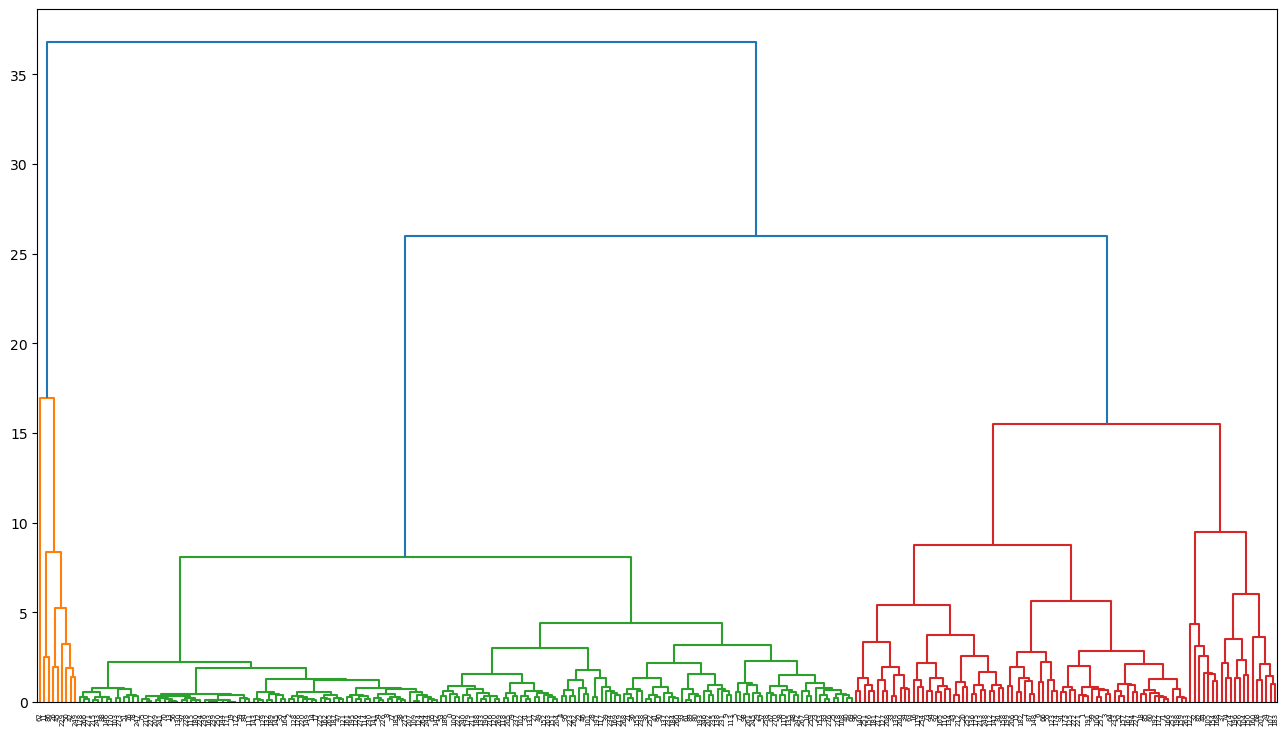

In [149]:
#Сделаем график побольше
from matplotlib import pyplot as plt
plt.figure(figsize = (16, 9))
dendrogram(ward_clustering);

In [90]:
crime["cluster"] = cluster_labels

## Задание 3a

In [91]:
crime["cluster"].value_counts()

0    174
1     75
3     20
2      8
4      1
Name: cluster, dtype: int64

In [92]:
crime.groupby("cluster").agg("mean", numeric_only = True)

,ASSAULT,BURGLARY,HOMICIDE,LARCENY,RAPE,ROBBERY
cluster,,,,,,
0,110.752874,80.770115,1.787356,161.408046,2.701149,38.465517
1,387.240000,205.680000,8.093333,474.160000,7.880000,120.066667
2,1549.000000,759.000000,34.250000,1193.625000,31.125000,408.625000
3,770.950000,438.000000,12.950000,1146.550000,15.750000,247.400000
4,2892.000000,486.000000,19.000000,4764.000000,83.000000,1146.000000


In [93]:
crime.groupby("cluster").agg("median", numeric_only = True)

,ASSAULT,BURGLARY,HOMICIDE,LARCENY,RAPE,ROBBERY
cluster,,,,,,
0,93.5,63.0,1.0,147.0,2.0,34.0
1,379.0,180.0,9.0,438.0,7.0,115.0
2,1571.0,699.0,34.0,1066.0,32.5,349.5
3,854.0,407.0,11.5,1019.0,16.0,251.0
4,2892.0,486.0,19.0,4764.0,83.0,1146.0


#### Мы сразу видим, что есть кластер, состоящий из одного района с наибольшей преступностью – Даунтаун. 

#### Нулевой кластер (большая часть районов) относительно безопасна: за счет сильного деления северной части города, имеются много маленьких «белых» пригородных районов с низкой плотностью заселения. 

#### Районы первого кластера – индустриальные, с низкой плотностью застройки

#### Районы второго кластера – либо самые плотно заселенные (Frankford), либо low-income (например, в Cherry Hills находится самый крупный public housing во всем городе), либо геттоизированны (Uptown – старейший центр black community).

#### Районы третьего кластера – иммигрантские, но туристские (Fell's point) 

In [75]:
#Создаем пять списков с районами для каждого кластера
cluster_0 = crime.index[df['cluster'] == 0].tolist()
cluster_1 = crime.index[df['cluster'] == 1].tolist()
cluster_2 = crime.index[df['cluster'] == 2].tolist()
cluster_3 = crime.index[df['cluster'] == 3].tolist()
cluster_4 = crime.index[df['cluster'] == 4].tolist()

## Задание 3b

In [94]:
#Создаем отдельные датасеты для каждого кластера
crime_0 = df[crime['cluster'] == 0]
crime_1 = df[crime['cluster'] == 1]
crime_2 = df[crime['cluster'] == 2]
crime_3 = df[crime['cluster'] == 3]
crime_4 = df[crime['cluster'] == 4]

## Задание 3c

In [95]:
import seaborn as sns

<AxesSubplot:xlabel='cluster', ylabel='ASSAULT'>

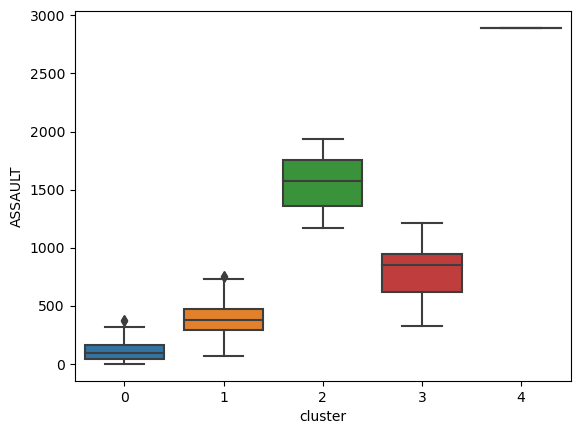

In [96]:
sns.boxplot(data = crime, x = "cluster", y = "ASSAULT")

<AxesSubplot:xlabel='cluster', ylabel='RAPE'>

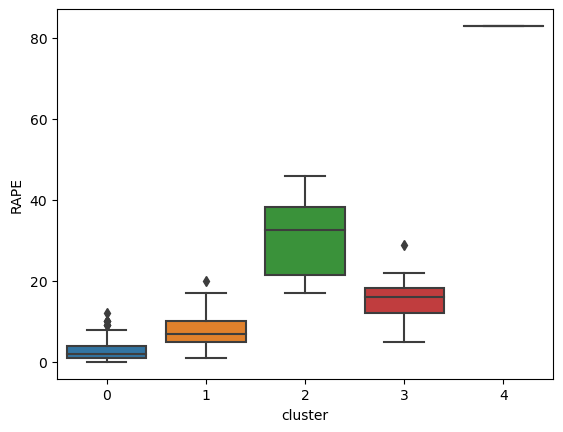

In [97]:
sns.boxplot(data = crime, x = "cluster", y = "RAPE")

<AxesSubplot:xlabel='cluster', ylabel='ROBBERY'>

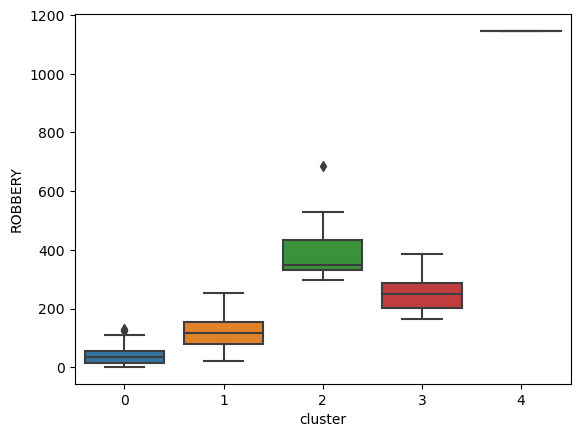

In [98]:
sns.boxplot(data = crime, x = "cluster", y = "ROBBERY")

#### Интерпретация: это странно, но средние кластеров вообще не пересекаются между собой. Можно предположить, что все преступления между собой связаны и нет кластеров, где чего-то больше и чего-то меньше: либо все больше, либо все меньше.  Ну и Даунтаун впереди всего города с большим отрывом.

## Задание 3d

#### Тяжело предположить, что все-таки тут нормальное распределение, поэтому не будем делать тесты Шапиро-Уилка и тест Левена, сразу пропустим ANOVA.  У нас число кластеров больше двух, объемы выборок не очень большие, поэтому возьмем критерий Краскела-Уоллиса. Не будем брать в расчет кластер с Даутауном. Таким образом, n = 4.

In [100]:
from scipy.stats import kruskal

In [101]:
kruskal(crime_0["ASSAULT"], crime_1["ASSAULT"], crime_2["ASSAULT"], crime_3["ASSAULT"])

#H_0 отвергается

KruskalResult(statistic=178.86984505332745, pvalue=1.5471172746625118e-38)

In [102]:
kruskal(crime_0["BURGLARY"], crime_1["BURGLARY"], crime_2["BURGLARY"], crime_3["BURGLARY"])

#H_0 отвергается

KruskalResult(statistic=138.94027495250242, pvalue=6.39660411563347e-30)

In [104]:
kruskal(crime_0["HOMICIDE"], crime_1["HOMICIDE"], crime_2["HOMICIDE"], crime_3["HOMICIDE"])

#H_0 отвергается

KruskalResult(statistic=118.29240974414994, pvalue=1.7995917943795508e-25)

In [105]:
kruskal(crime_0["LARCENY"], crime_1["LARCENY"], crime_2["LARCENY"], crime_3["LARCENY"])

#H_0 отвергается

KruskalResult(statistic=149.04195633598957, pvalue=4.240624921333031e-32)

In [106]:
kruskal(crime_0["RAPE"], crime_1["RAPE"], crime_2["RAPE"], crime_3["RAPE"])

#H_0 отвергается

KruskalResult(statistic=140.45580815495921, pvalue=3.0142437536159353e-30)

In [107]:
kruskal(crime_0["ROBBERY"], crime_1["ROBBERY"], crime_2["ROBBERY"], crime_3["ROBBERY"])

#H_0 отвергается

KruskalResult(statistic=161.3353093733048, pvalue=9.439625386797626e-35)

#### Везде нулевая гипотеза (о том, что выборки взяты из одного распределения) отвергается, соответственно различия между всеми кластерами есть. Судя по результатам проверки, кластеры получились формально логичными!

## Задание 4

In [108]:
from sklearn.cluster import KMeans

In [120]:
kmeans = KMeans(n_clusters=5, random_state=1234).fit(to_clust)

In [121]:
clusters_kmeans = kmeans.labels_
crime["cluster_k"] = clusters_kmeans
crime.head()

,ASSAULT,BURGLARY,HOMICIDE,LARCENY,RAPE,ROBBERY,cluster,cluster_k
Neighborhood,,,,,,,,
Abell,147.0,122.0,1.0,269.0,1.0,90.0,0,1
Allendale,368.0,255.0,13.0,283.0,6.0,78.0,1,0
Arcadia,105.0,86.0,0.0,103.0,0.0,18.0,0,1
Arlington,417.0,180.0,11.0,301.0,7.0,110.0,1,0
Armistead Gardens,289.0,192.0,1.0,305.0,5.0,54.0,0,1


In [122]:
crime["cluster_k"].value_counts()

1    166
0     84
4     19
2      8
3      1
Name: cluster_k, dtype: int64

In [128]:
crimek_0 = df[crime['cluster_k'] == 0]
crimek_1 = df[crime['cluster_k'] == 1]
crimek_2 = df[crime['cluster_k'] == 2]
crimek_3 = df[crime['cluster_k'] == 3]
crimek_4 = df[crime['cluster_k'] == 4]

In [132]:
set0_ward = set(crime_0.index)
set1_ward = set(crime_1.index)
set2_ward = set(crime_2.index)
set3_ward = set(crime_3.index)
set4_ward = set(crime_4.index)

set0_kmeans = set(crimek_0.index)
set1_kmeans = set(crimek_1.index)
set2_kmeans = set(crimek_2.index)
set3_kmeans = set(crimek_3.index)
set4_kmeans = set(crimek_4.index)

In [135]:
print(len(set0_ward.intersection(set1_kmeans)))
print(len(set1_ward.intersection(set0_kmeans)))
print(len(set2_ward.intersection(set2_kmeans)))
print(len(set3_ward.intersection(set4_kmeans)))
print(len(set4_ward.intersection(set3_kmeans)))

160
69
8
19
1


Итого, соотношение такое:

* кластер 0 по методу Варда – это кластер 1 по методу k-means;
* кластер 1 по методу Варда – это кластер 0 по методу k-means;
* кластер 2 по методу Варда – это кластер 2 по методу k-means;
* кластер 3 по методу Варда – это кластер 4 по методу k-means;
* кластер 4 по методу Варда – это кластер 3 по методу k-means;

In [147]:
print(cluster_0)

['Abell', 'Arcadia', 'Armistead Gardens', 'Ashburton', 'Barre Circle', 'Bayview', 'Beechfield', 'Belair-Parkside', 'Bellona-Gittings', 'Belvedere', 'Beverly Hills', 'Blythewood', 'Boyd-Booth', 'Brewers Hill', 'Bridgeview/Greenlawn', 'Broening Manor', 'Burleith-Leighton', "Butcher's Hill", 'CARE', 'Callaway-Garrison', 'Cameron Village', 'Carroll Park', 'Carroll-South Hilton', 'Cedarcroft', 'Cedmont', 'Cedonia', 'Central Forest Park', 'Cheswolde', 'Chinquapin Park', 'Clifton Park', 'Coldspring', 'Concerned Citizens Of Forest Park', 'Cross Country', 'Cross Keys', 'Curtis Bay Industrial Area', 'Cylburn', 'Darley Park', 'Dickeyville', 'Dorchester', 'Druid Hill Park', 'East Arlington', 'Easterwood', 'Eastwood', 'Edmondson Village', 'Evergreen', 'Evergreen Lawn', 'Evesham Park', 'Fairfield Area', 'Fairmont', 'Fallstaff', 'Forest Park', 'Forest Park Golf Course', 'Franklintown', 'Franklintown Road', 'Garwyn Oaks', 'Glen Oaks', 'Graceland Park', 'Greenmount Cemetery', 'Greenmount West', 'Grove 

#### Интерпретация (везде кластеры по Варду):

0. Нулевой кластер – это преимущественно север города с районами низкой плотности и одноэтажной застройки, в котором живет средний класс. Чаще всего в таких районах живет белое население со своими частными домами.

1. В первый кластер включены индустриальные районы, они мало заселены, поэтому в абсолютном значении количество преступлений там меньше. Тем не менее, там есть и геттоизированные районы, однако население там >1000 и по той же самой причине преступлений меньше. 

2. Районы второго кластера – либо самые плотно заселенные (Frankford), либо low-income (например, в Cherry Hills находится самый крупный public housing во всем городе), либо геттоизированны (Uptown – старейший центр black community).

3. Районы третьего кластера – это преимущественно бывшие индустриальные районы (как Fell's Point, Inner Harbour или Hampden), которые подверглись редевелопменту и стали туристическими местами (этим, например, может объясняться высокое количество краж – "Larceny").

4. В четвертом кластере выделен Downtown, центральный район города, где происходит крайне много преступлений. Я бы предположил несколько причин: во-первых, в центре преступления лучше регистрируются, во-вторых центр является ареной взаимодействия нескольких преступных группировок (как нейтральная территория), в-третьих в Даунтауне распологается крупный лагерь бездомных людей, многие из которых являются наркозависимыми.

## Задание 5

In [136]:
import geopandas

In [137]:
gdf = geopandas.read_file("Neighborhoods.geojson")
gdf.head()

,name,geometry
0,Abell,"POLYGON ((-76.61113 39.32345, -76.61060 39.323..."
1,Allendale,"POLYGON ((-76.67263 39.29184, -76.67330 39.291..."
2,Arcadia,"POLYGON ((-76.56853 39.33595, -76.56859 39.336..."
3,Arlington,"POLYGON ((-76.68627 39.34791, -76.68601 39.347..."
4,Armistead Gardens,"POLYGON ((-76.55880 39.30646, -76.55860 39.306..."


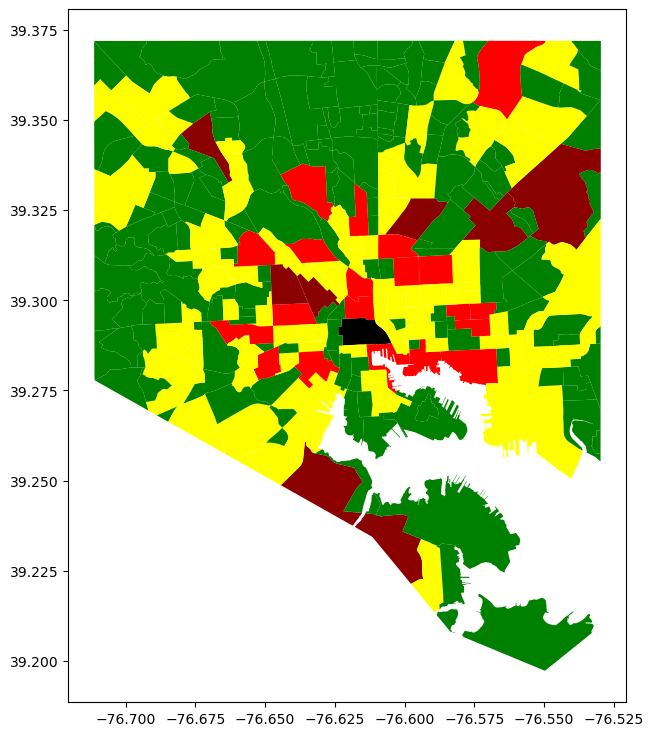

In [150]:
fin = crime.merge(gdf, left_on = crime.index, right_on = "name")
fin_gp = geopandas.GeoDataFrame(fin)
fin_gp["color"] = fin_gp["cluster"]
convert = {0 : "green", 1: "yellow", 3 : "red", 2 : "darkred", 4: "black"} 
fin_gp = fin_gp.replace({"color" : convert})
fin_gp.plot(color = fin_gp["color"], figsize = (16, 9));

#### Интерпретация:

Крайне интересно наблюдать разницу распространения преступности в Балтиморе и в Москве. Несмотря на то, что в Москве в центре происходят много преступлений, крайне малый процент из них – насильственные (больше экономических). А вот ближе ко МКАДу количество насильственных преступлений постепенно увеличивается. В Балтиморе все не совсем так.

В центре города больше преступлений, чем на его окраинах. Это и понятно: все больше и больше населения среднего класса уезжает от преступности в отдаленные пригороды, а в центре появляются гетто. Это усугубляется опиоидным кризисом и ростом бездомных людей, которые предпочитают селиться не в элитные пригороды, где слишком велик риск встретиться с разъяренными жителями, а в Даунтауне, образуя большие палаточные лагеря – там есть вся «инфраструктура»: шелтеры, благотворительные организации и, к сожалению, опиоиды. 